In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
document.title='Aurora app'

<IPython.core.display.Javascript object>

In [ ]:
import ipywidgets as ipw
from IPython.display import display
import numpy as np
import pandas as pd
from collections import OrderedDict
import json
import aurora
import pickle
# import schemas.data_schemas
# from schemas.data_schemas import BatterySpecs, BatteryComposition, BatteryCapacity, BatteryMetadata, BatterySample, BatterySpecsJsonTypes, BatterySampleJsonTypes

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib widget

In [2]:
from aurora.interface.main import MainPanel

In [4]:
w_main = MainPanel()
display(w_main)

MainPanel(children=(HTML(value='<h2>Aurora</h2>'), Accordion(children=(Tab(children=(SampleFromId(children=(HT…

***AURORA* Autonomous Robotic Battery Innovation Platform**  BIG-MAP Stakeholder Initiative 2021

<table style="width: 40%; border-collapse: collapse; border-style: hidden; float: left;">
<tbody>
<tr>
<td style="width: 15%;"><img src="aurora/images/BIG-MAP_logo.png" alt="BIG-MAP" style="margin: 2px"/></td>
<td style="width: 15%;"><img src="aurora/images/Battery2030_logo.png" alt="Battery 2030+" style="margin: 2px"/></td>
<td style="width: 15%;"><img src="aurora/images/EU_logo.png" alt="European Commision" style=" margin: 2px"/></td>
<td style="width: 30%;"><img src="aurora/images/Empa_logo.png" alt="Empa" style="margin: 2px"/></td>
<td style="width: 25%;"><img src="aurora/images/EPFL_logo.png" alt="EPFL" style="margin: 2px"/></td>
</tr>
</tbody>
</table>


In [3]:
%aiida

Loaded AiiDA DB environment - profile name: default.

In [49]:
import aurora
from aurora.schemas.battery import BatterySample as BatterySampleSchema, BatteryState as BatteryStateSchema
from aurora.schemas.cycling import Dummy, ElectroChemSequence
# from aurora.schemas.tomato_0p2 import Tomato
import aiida
from aiida.engine import submit
from aiida.plugins import DataFactory, CalculationFactory

In [5]:
import aiida_aurora
from aiida.orm import load_code

BatterySampleData = DataFactory('aurora.batterysample')
CyclingSpecsData = DataFactory('aurora.cyclingspecs')
TomatoSettingsData = DataFactory('aurora.tomatosettings')
BatteryCyclerExperiment = CalculationFactory('aurora.cycler')

TomatoMonitorData = DataFactory('calcmonitor.monitor.tomatobiologic')
TomatoMonitorCalcjob = CalculationFactory('calcmonitor.calcjob_monitor')

In [6]:
g_samples = Group.get(label='Empa-samples')
g_methods = Group.get(label='Empa-methods')
g_exp = Group.get(label='Empa-exp')
g_tomato = Group.get(label='Empa-tomato')
g_monitor_params = Group.get(label='Empa-monitor-params')

In [20]:
list(g_samples.nodes)

[<BatterySampleData: uuid: 1b647389-37c7-4f68-83eb-29a5e0bc76c8 (pk: 237)
 {'capacity': {'units': 'mAh', 'actual': None, 'nominal': 0.002262}, 'metadata': {'name': '190822_Aurora_9', 'creation_process': 'Built by Empa', 'creation_datetime': '2022-08-22T05:59:00+00:00'}, 'battery_id': 109, 'composition': {'description': 'unknown'}, 'form_factor': '2032', 'manufacturer': 'Empa'}>,
 <BatterySampleData: uuid: 9cc2b088-ef45-4ef0-96da-20a9637f3ce4 (pk: 242)
 {'capacity': {'units': 'mAh', 'actual': None, 'nominal': 0.002262}, 'metadata': {'name': '190822_Aurora_11', 'creation_process': 'Built by Empa', 'creation_datetime': '2022-08-22T05:59:00+00:00'}, 'battery_id': 111, 'composition': {'description': 'unknown'}, 'form_factor': '2032', 'manufacturer': 'Empa'}>,
 <BatterySampleData: uuid: 9980e3b8-97d7-40da-9c15-b23cd4c9673c (pk: 244)
 {'capacity': {'units': 'mAh', 'actual': None, 'nominal': 0.002262}, 'metadata': {'name': '190822_Aurora_12', 'creation_process': 'Built by Empa', 'creation_date

In [21]:
list(g_methods.nodes)

[<CyclingSpecsData: uuid: 741a3c27-b934-4b54-bd5e-a0a1634137a8 (pk: 238)
 {'method': [{'name': 'CC_1', 'device': 'MPG2', 'technique': 'constant_current', 'parameters': {'time': {'label': 'Time:', 'units': 's', 'value': 36000.0, 'required': True, 'description': 'Maximum duration of the CC step', 'default_value': 0.0}, 'E_range': {'label': 'E range', 'units': '', 'value': '+-5.0 V', 'required': True, 'description': 'Select the voltage range of the potentiostat', 'default_value': 'auto'}, 'I_range': {'label': 'I range', 'units': '', 'value': '1 mA', 'required': True, 'description': 'Select the current range of the potentiostat', 'default_value': 'keep'}, 'current': {'label': 'Step current:', 'units': 'I', 'value': 'C/10', 'required': True, 'description': 'Current during the current step', 'default_value': 0.0}, 'is_delta': {'label': 'Δ$I$:', 'units': '', 'value': False, 'required': True, 'description': 'Is the step current a $\\Delta$ from previous step?', 'default_value': False}, 'n_cycl

## 1. Formation

In [27]:
sample_node = aiida_aurora.data.BatterySampleData(w_main.selected_battery_sample.dict())
sample_node.store()
g_samples.add_nodes(sample_node)

# 237 242 244
# sample_node = load_node(237)
print(sample_node.id, sample_node.label)

315 190822_Aurora_16


In [28]:
# method_node = aiida_aurora.data.CyclingSpecsData(w_main.selected_cycling_protocol.dict())
# method_node.store()
# method_node.label = 'Empa-formation-new'
# g_methods.add_nodes(method_node)
method_node = load_node(238)
print(method_node.id, method_node.label)

238 Empa-formation-new


In [29]:
# tomato_sett = aurora.schemas.dgbowl_schemas.Tomato_0p2(
#     unlock_when_done = True,)
# tomato_sett_node = aiida_aurora.data.TomatoSettingsData(tomato_sett.dict())
# tomato_sett_node.label = 'tomato-True-no_monitor'
# tomato_sett_node.store()
# g_tomato.add_nodes(tomato_sett_node)
tomato_sett_node = load_node(239)
print(tomato_sett_node.id, tomato_sett_node.label)

239 tomato-True-no_monitor


In [30]:
b = aiida_aurora.calculations.BatteryCyclerExperiment.get_builder()
code = load_code('ketchup-0.2rc1@ddm07162')
b.battery_sample = sample_node
b.code = code
b.technique = method_node
b.control_settings = tomato_sett_node

In [40]:
# aurora.schemas.dgbowl_schemas.conversion_map['0.2']['sample'](sample_node.get_dict())

In [31]:
job = submit(b)
job.label = f"{b.battery_sample.label}-formation"
g_exp.add_nodes(job)
print(job.id, job.label)

08/30/2022 12:17:06 PM <13813> aiida.engine.persistence: [DEBUG] Persisting process<316>
08/30/2022 12:17:06 PM <13813> aiida.engine.persistence: [DEBUG] Persisting process<316>


316 190822_Aurora_16-formation


In [57]:
# job = load_node(222)
# print(job.label)

formation-Aurora-8


## 2. Cycling

In [32]:
# sample_node = aiida_aurora.data.BatterySampleData(w_main.selected_battery_sample.dict())
# sample_node.store()
# g_samples.add_nodes(sample_node)

# 237 242 244
sample_node = load_node(315)
print(sample_node.id, sample_node.label)

315 190822_Aurora_16


In [33]:
# method_node = aiida_aurora.data.CyclingSpecsData(w_main.selected_cycling_protocol.dict())
# method_node.store()
# method_node.label = 'Empa-cycling-new'
# g_methods.add_nodes(method_node)
method_node = load_node(250)
print(method_node.id, method_node.label)

250 Empa-cycling-new


In [34]:
# tomato_sett = aurora.schemas.dgbowl_schemas.Tomato_0p2(
#     unlock_when_done = True,
#     snapshot = {'frequency': 600, 'prefix': 'snapshot'}
# )
# tomato_sett_node = aiida_aurora.data.TomatoSettingsData(tomato_sett.dict())
# tomato_sett_node.label = 'tomato-True-monitor_600'
# tomato_sett_node.store()
# g_tomato.add_nodes(tomato_sett_node)
tomato_sett_node = load_node(251)
print(tomato_sett_node.id, tomato_sett_node.label)

251 tomato-True-monitor_600


In [35]:
b = aiida_aurora.calculations.BatteryCyclerExperiment.get_builder()
code = load_code('ketchup-0.2rc1@ddm07162')
b.battery_sample = sample_node
b.code = code
b.technique = method_node
b.control_settings = tomato_sett_node

In [36]:
job = submit(b)
job.label = f"{b.battery_sample.label}-cycling"
g_exp.add_nodes(job)
print(job.id, job.label)

08/30/2022 12:17:28 PM <13813> aiida.engine.persistence: [DEBUG] Persisting process<317>
08/30/2022 12:17:28 PM <13813> aiida.engine.persistence: [DEBUG] Persisting process<317>


317 190822_Aurora_16-cycling


In [8]:
# monitor_protocol = TomatoMonitorData(dict={
#     'sources': {
#         'output': {'filepath': 'snapshot.json', 'refresh_rate': 600},
#     },
#     'options': {
#         'check_type': 'discharge_capacity',
#         'consecutive_cycles': 2,
#         'threshold': 0.80,
#     },
#     'retrieve': ['results.json'],
#     'retrieve_temporary': ['results.zip']
# })
# monitor_protocol.store()
# monitor_protocol.label = 'monitor-rate_600-cycles_2-thr_0.80'
# g_monitor_params.add_nodes(monitor_protocol)
monitor_protocol = load_node(253)
print(monitor_protocol.id, monitor_protocol.label)

253 monitor-rate_600-cycles_2-thr_0.80


In [10]:
job = load_node(317)
monitor_builder = TomatoMonitorCalcjob.get_builder()
monitor_builder.code = load_code('monitor@localhost-verdi')
monitor_builder.metadata.options.parser_name = 'calcmonitor.cycler'
monitor_builder.monitor_protocols = {'monitor1': monitor_protocol}
monitor_builder.monitor_folder = job.outputs.remote_folder
mjob = submit(monitor_builder)
mjob.label = f"{job.label}-monitor"
print(mjob.id, mjob.label)

09/05/2022 08:48:41 AM <1602> aiida.engine.persistence: [DEBUG] Persisting process<334>
09/05/2022 08:48:41 AM <1602> aiida.engine.persistence: [DEBUG] Persisting process<334>


334 190822_Aurora_16-cycling-monitor


## 3. Discharge

In [39]:
# sample_node = aiida_aurora.data.BatterySampleData(w_main.selected_battery_sample.dict())
# sample_node.store()
# g_samples.add_nodes(sample_node)

# 237 242 244
sample_node = load_node(315)
print(sample_node.id, sample_node.label)

315 190822_Aurora_16


In [40]:
# method_node = aiida_aurora.data.CyclingSpecsData(w_main.selected_cycling_protocol.dict())
# method_node.store()
# method_node.label = 'Empa-discharge-new'
# g_methods.add_nodes(method_node)
method_node = load_node(268)
print(method_node.id, method_node.label)

268 Empa-discharge-new


In [41]:
# tomato_sett = aurora.schemas.dgbowl_schemas.Tomato_0p2(
#     unlock_when_done = False,)
# tomato_sett_node = aiida_aurora.data.TomatoSettingsData(tomato_sett.dict())
# tomato_sett_node.label = 'tomato-False-no_monitor'
# tomato_sett_node.store()
# g_tomato.add_nodes(tomato_sett_node)
tomato_sett_node = load_node(269)
print(tomato_sett_node.id, tomato_sett_node.label)

269 tomato-False-no_monitor


In [42]:
b = aiida_aurora.calculations.BatteryCyclerExperiment.get_builder()
code = load_code('ketchup-0.2rc1@ddm07162')
b.battery_sample = sample_node
b.code = code
b.technique = method_node
b.control_settings = tomato_sett_node

In [43]:
job = submit(b)
job.label = f"{b.battery_sample.label}-discharge"
g_exp.add_nodes(job)
print(job.id, job.label)

08/30/2022 12:18:26 PM <13813> aiida.engine.persistence: [DEBUG] Persisting process<322>
08/30/2022 12:18:26 PM <13813> aiida.engine.persistence: [DEBUG] Persisting process<322>


322 190822_Aurora_16-discharge


## Results Analysis

In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import json
import aurora
import pickle
# import schemas.data_schemas
# from schemas.data_schemas import BatterySpecs, BatteryComposition, BatteryCapacity, BatteryMetadata, BatterySample, BatterySpecsJsonTypes, BatterySampleJsonTypes

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib widget

In [2]:
import itertools

def get_data_from_raw(jsdata):
    "Extract raw data from json file."
    if not isinstance(jsdata, dict):
        raise TypeError('jsdata should be a dictionary')
    if len(jsdata["steps"]) > 1:
        raise NotImplementedError('Analysis of multiple steps is not implemented.')

    raw_data = jsdata["steps"][0]["data"]

    # extract raw data
    t = np.array([ts["uts"] for ts in raw_data]) - raw_data[0]["uts"]
    Ewe = np.array([ts["raw"]["Ewe"]["n"] for ts in raw_data])
    I = np.array([ts["raw"]["I"]["n"] for ts in raw_data])
    cn = np.array([ts["raw"]["cycle number"] for ts in raw_data])

    # find indices of sign changes in I
    idx = np.where(np.diff(np.sign(I)) != 0)[0]

    # integrate and store charge and discharge currents
    Qc, Qd = [], []
    for ii in range(len(idx) - 1):
        i0, ie = idx[ii], idx[ii+1]
        q = np.trapz(I[i0:ie], t[i0:ie])
        if q > 0:
            Qc.append(q)
        else:
            Qd.append(abs(q))
    data = {
        'time': t,
        'Ewe': Ewe,
        'I': I,
        'cn': cn,
        'time-cycles': t[idx[2::2]],
        'Qd': np.array(Qd),
        'Qc': np.array(Qc)
    }
    return data

def get_data_from_results(array_node):
    "Extract data from parsed ArrayData node."
    if not isinstance(array_node, aiida.orm.ArrayData):
        raise TypeError('array_node should be an ArrayData')

    # collect data
    t = array_node.get_array('step0_uts')
    t -= t[0]
    Ewe = array_node.get_array('step0_Ewe_n')
    I = array_node.get_array('step0_I_n')
    cn = array_node.get_array('step0_cycle_number')

    # find indices of sign changes in I
    idx = np.where(np.diff(np.sign(I)) != 0)[0]

    # integrate and store charge and discharge currents
    Qc, Qd = [], []
    for ii in range(len(idx) - 1):
        i0, ie = idx[ii], idx[ii+1]
        q = np.trapz(I[i0:ie], t[i0:ie])
        if q > 0:
            Qc.append(q)
        else:
            Qd.append(abs(q))
    data = {
        'time': t,
        'Ewe': Ewe,
        'I': I,
        'cn': cn,
        'time-cycles': t[idx[2::2]],
        'Qd': np.array(Qd),
        'Qc': np.array(Qc)
    }
    return data

def get_data_from_cycling_calcjob(calcjob):
    output_labels = calcjob.get_outgoing().all_link_labels()
    if 'results' in output_labels:
        print('Analysing output results')
        res = calcjob.outputs.results
        return get_data_from_results(res)
    elif 'raw_data' in output_labels and 'results.json' in calcjob.outputs.raw_data.list_object_names():
        print('Analysing output raw_data')
        jsdata = json.loads(calcjob.outputs.raw_data.get_object_content('results.json'))
        return get_data_from_raw(jsdata)
    elif 'retrieved' in output_labels and 'results.json' in calcjob.outputs.retrieved.list_object_names():
        print('Analysing retrieved results.json file')
        jsdata = json.loads(calcjob.outputs.retrieved.get_object_content('results.json'))
        return get_data_from_raw(jsdata)
    else:
        print('Monitored CalcJob: no output found.')
        return None

def get_data_from_monitor_calcjob(monitor_calcjob):
    output_labels = monitor_calcjob.get_outgoing().all_link_labels()
    if 'redirected_outputs__results' in output_labels:
        print('Analysing redirected output results')
        res = monitor_calcjob.outputs.redirected_outputs.results
        return get_data_from_results(res)
    elif 'redirected_outputs__raw_data' in output_labels and 'results.json' in monitor_calcjob.outputs.redirected_outputs.raw_data.list_object_names():
        print('Analysing redirected output raw_data')
        jsdata = json.loads(monitor_calcjob.outputs.redirected_outputs.get_object_content('results.json'))
        return get_data_from_raw(jsdata)
    elif 'retrieved' in output_labels and 'results.json' in monitor_calcjob.outputs.retrieved.list_object_names():
        print('Analysing retrieved results.json file')
        jsdata = json.loads(monitor_calcjob.outputs.retrieved.get_object_content('results.json'))
        return get_data_from_raw(jsdata)
    elif 'remote_folder' in output_labels:
        try:
            print('Analysing last snapshot.json file')
            with open(f"{monitor_calcjob.outputs.remote_folder.get_attribute('remote_path')}/snapshot.json", 'r') as fileobj:
                jsdata = json.load(fileobj)
            return get_data_from_raw(jsdata)
        except FileNotFoundError:
            print('Monitor CalcJob: no output found.')
            return None
    else:
        return None

def get_data_from_cycling_or_monitor_calcjob(calcjob_node):
    """You can provide either the cycler or the monitor calcjob.
    First, it will try to find and analyse any output of the cycler calcjob.
    If this does not succeed, the monitor calcjob outputs will be analysed (the results or the last snapshot)."""
    
    if calcjob_node.process_type == 'aiida.calculations:aurora.cycler':
        calcjob = calcjob_node
        # find last monitor, if existing
        qb = QueryBuilder()
        qb.append(aiida.orm.RemoteData, filters={'uuid': calcjob.outputs.remote_folder.uuid}, tag='rf')
        qb.append(CalcJobNode, with_incoming='rf', edge_filters={'label': 'monitor_folder'}, project=['*', 'id'], tag='mon')
        qb.order_by({'mon': {'id': 'desc'}})
        monitor_calcjob = qb.first()[0] if qb.count() else None
    elif calcjob_node.process_type == 'aiida.calculations:calcmonitor.calcjob_monitor':
        monitor_calcjob = calcjob_node
        calcjob = monitor_calcjob.inputs.monitor_folder.get_incoming().get_node_by_label('remote_folder')
    else:
        raise TypeError('calcjob_node should be a BatteryCyclerExperiment or a CalcjobMonitor')

    if monitor_calcjob:
        print(f"Monitored CalcJob:   <{calcjob.id}> '{calcjob.label}'")
        print(f"Monitor CalcJob:     <{monitor_calcjob.id}> '{monitor_calcjob.label}'")
    else:
        print(f"CalcJob:             <{calcjob.id}> '{calcjob.label}'")

    sample = calcjob.inputs.battery_sample
    print(f"Sample:              {sample.label}")

    if not monitor_calcjob:
        # unmonitored job
        data = get_data_from_cycling_calcjob(calcjob)
    else:
        # monitored job
        # NOTE this logic should be changed once we make sure that the monitor job/workchain always has the output
        # here I want to make sure that we do not read a snapshot, if the calcjob has an output
        # if it does not have an output, it means that it was killed by the monitor
        try:
            data = get_data_from_cycling_calcjob(calcjob)
        except Exception as err:
            print(err)
            data = get_data_from_monitor_calcjob(monitor_calcjob)
        else:
            if data is None:
                data = get_data_from_monitor_calcjob(monitor_calcjob)
    return data

def get_capacities(data_dic, discharge=True):
    if discharge:
        return data_dic['Qd']
    else:
        return data_dic['Qc']

def analyze_cycling_results(data, consecutive_cycles, threshold, discharge):
    """Analyse cycling results.
    `data` should be a dictionary generated by `get_data_from_*`.
    """
    Qs = get_capacities(data, discharge=discharge)
    print(f"  capacities:          {Qs}")
    print(f"  relative capacities: {Qs / Qs[0]}")

    print(f"Completed {len(Qs)} cycles.")
    if len(Qs) >= consecutive_cycles + 1:
        below_thresh = Qs < threshold * Qs[0]
        below_groups = [sum(1 for _ in g) for k, g in itertools.groupby(below_thresh) if k]
        for g in below_groups:
            if g > consecutive_cycles:
                print(f'Below threshold for {g} cycles!')

def monitor_analysis(calcjob_node, consecutive_cycles=2, threshold=0.8, discharge=True):
    """Perform the cycling analysis. You can provide either the cycler or the monitor calcjob.
    First, it will try to find and analyse any output of the cycler calcjob.
    If this does not succeed, the monitor calcjob outputs will be analysed (the results or the last snapshot)."""

    data = get_data_from_cycling_or_monitor_calcjob(calcjob_node)
    analyze_cycling_results(data, consecutive_cycles, threshold, discharge)
    return data

In [210]:
n = load_node(254)
n.id, n.label, n

(254,
 '190822_Aurora_9-cycling',
 <CalcJobNode: uuid: a824c022-be7c-47d6-b3e6-ee88fb257918 (pk: 254) (aiida.calculations:aurora.cycler)>)

In [211]:
monitor_analysis(n, consecutive_cycles=2, threshold=0.8, discharge=True)

Monitored CalcJob:   <254> '190822_Aurora_9-cycling'
Monitor CalcJob:     <285> '190822_Aurora_9-cycling-monitor'
Sample:              190822_Aurora_9
Analysing output results
  capacities:          [0.26599113 0.31483657 0.34394795 0.36161585 0.37255043 0.37942505
 0.38366151 0.38728568 0.39001621 0.39103339 0.39239334 0.39404807
 0.3942665  0.39468386 0.3958876  0.39637609 0.39726074 0.39769717
 0.398619   0.39838338 0.39923678 0.39940582 0.40035159 0.40043862
 0.4006609  0.40126616 0.40216468 0.4025786  0.40275311 0.40287753
 0.40354268 0.4035563  0.40421213 0.4038989  0.40421974 0.40381415
 0.40447495 0.40505721 0.4055342  0.40550938 0.40567567 0.40556829
 0.40603514 0.40664091 0.40658437 0.4061572  0.40752343 0.40724666
 0.40742543 0.40735489 0.40742995 0.4078451  0.40802575 0.40813327
 0.40808969 0.40878473 0.40705623 0.40866688 0.40826171 0.40886836
 0.40812768 0.40889283 0.40856988 0.4083921  0.40833493 0.40858822
 0.40867417 0.4087752  0.40875071 0.40839104 0.40860314 0.409010

{'time': array([0.00000000e+00, 1.19924545e-04, 1.35993958e-03, ...,
        7.25758411e+04, 7.25777959e+04, 7.25789312e+04]),
 'Ewe': array([1.34385943, 1.80051911, 1.82072699, ..., 1.03160977, 1.01156235,
        0.99985456]),
 'I': array([ 0.        ,  0.00110694,  0.001109  , ..., -0.00111409,
        -0.00111401, -0.00111378]),
 'cn': array([0, 0, 0, ..., 0, 0, 0]),
 'time-cycles': array([  559.00200009,  1157.63899994,  1802.375     ,  2474.52999997,
         3163.13599992,  3861.523     ,  4565.41799998,  5274.25999999,
         5986.69099998,  6699.77200007,  7414.43300009,  8131.26200008,
         8847.8440001 ,  9564.54500008, 10282.93700004, 11001.80200005,
        11721.87899995, 12442.37299991, 13164.21000004, 13885.29099989,
        14607.71199989, 15330.25099993, 16054.19400001, 16778.17499995,
        17502.38899994, 18227.52399993, 18954.10400009, 19681.31100011,
        20408.71099997, 21136.13700008, 21864.70700002, 22593.21399999,
        23322.82200003, 24051.73799

## plots

In [190]:
g_samples = Group.get(label='Empa-samples')

qbs = QueryBuilder()
qbs.append(Group, filters={'label': 'Empa-samples'}, tag='g')
qbs.append(BatterySampleData, with_group='g', tag='s')

In [191]:
[n.label for n in g_exp.nodes]

['190822_Aurora_9-formation',
 '190822_Aurora_11-formation',
 '190822_Aurora_12-formation',
 '190822_Aurora_9-cycling',
 '190822_Aurora_11-cycling',
 '190822_Aurora_12-cycling',
 '190822_Aurora_9-discharge',
 '190822_Aurora_11-discharge',
 '190822_Aurora_12-discharge',
 '190822_Aurora_15-formation',
 '190822_Aurora_15-cycling',
 '190822_Aurora_15-discharge',
 '190822_Aurora_16-formation',
 '190822_Aurora_16-cycling',
 '190822_Aurora_16-discharge']

In [213]:
d = {}
for sample, in qbs.iterall():
    d[sample.label] = []
    for key in ('formation', 'cycling', 'discharge'):
        print(f'\n* {sample.label} {key}')
        qb = QueryBuilder()
        qb.append(BatterySampleData, filters={'uuid': sample.uuid}, tag='s')
        qb.append(BatteryCyclerExperiment, tag='exp', filters={'label': {'like': f'%{key}'}})
        assert qb.count() == 1
        data = get_data_from_cycling_or_monitor_calcjob(qb.first()[0])
        d[sample.label].append(data)

with open('/home/aiida/data/cycling_data.pkl', 'wb') as f:
    pickle.dump(d, f)


* 190822_Aurora_9 formation
CalcJob:             <240> '190822_Aurora_9-formation'
Sample:              190822_Aurora_9
Analysing output results

* 190822_Aurora_9 cycling
Monitored CalcJob:   <254> '190822_Aurora_9-cycling'
Monitor CalcJob:     <285> '190822_Aurora_9-cycling-monitor'
Sample:              190822_Aurora_9
Analysing output results

* 190822_Aurora_9 discharge
CalcJob:             <270> '190822_Aurora_9-discharge'
Sample:              190822_Aurora_9
Analysing output results

* 190822_Aurora_11 formation
CalcJob:             <243> '190822_Aurora_11-formation'
Sample:              190822_Aurora_11
Analysing output results

* 190822_Aurora_11 cycling
Monitored CalcJob:   <258> '190822_Aurora_11-cycling'
Monitor CalcJob:     <287> '190822_Aurora_11-cycling-monitor'
Sample:              190822_Aurora_11
Monitored CalcJob: no output found.
Analysing redirected output results

* 190822_Aurora_11 discharge
CalcJob:             <271> '190822_Aurora_11-discharge'
Sample:         

### Reload pickle

In [3]:
# BASE_DIR = '/home/aiida/data'
BASE_DIR = '/mnt/d/Documents/EPFL/Aurora/Aurora_data_D2'

In [4]:
# with open('/home/aiida/data/cycling_data.pkl', 'rb') as f:
with open(f'{BASE_DIR}/cycling_data.pkl', 'rb') as f:
    cycl_data = pickle.load(f)

In [40]:
cycl_data.keys()

dict_keys(['190822_Aurora_9', '190822_Aurora_11', '190822_Aurora_12', '190822_Aurora_15', '190822_Aurora_16'])

In [12]:
cycl_data['190822_Aurora_16'][1]['I']

array([ 0.        ,  0.00111162,  0.00111192, ..., -0.00111132,
       -0.00111117, -0.00111102])

In [37]:
def get_capacity(t, I):
    # find indices of sign changes in I
    idx = np.where(np.diff(np.sign(I)) != 0)[0]

    # integrate and store charge and discharge currents
    Qc, Qd = [], []
    for ii in range(len(idx) - 1):
        i0, ie = idx[ii], idx[ii+1]
        q = np.trapz(I[i0:ie], t[i0:ie])
        if q > 0:
            Qc.append(q)
        else:
            Qd.append(abs(q))
    return Qc, Qd

In [38]:
Qc, Qd = get_capacity(cycl_data['190822_Aurora_16'][1]['time'] / 3600, cycl_data['190822_Aurora_16'][1]['I'] * 1000)

In [47]:
np.allclose(cycl_data['190822_Aurora_16'][1]['Qd'] / 3.6, Qd)

True

In [5]:
def plot_Ewe_I(data, name):
    f, ax = plt.subplots(3, figsize=(9,12))
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.05, top=0.95)
    for (i, axx), lab1, lab2 in zip(enumerate(ax), ['(a)', '(b)', '(c)'], ['[pretreatment]', '[cycling - monitored]', '[discharge]']):
        axx.plot(data[i]["time"] / 3600., data[i]["Ewe"], label='Ewe')
        axx.set_xlabel('t [h]')
        axx.set_ylabel('Ewe [V]', c='b')
        axx.text(0.985, 0.96, lab1, transform=axx.transAxes, ha='right', va='top', fontsize=12)
        axx.text(0.01, 1.015, lab2, transform=axx.transAxes, ha='left', va='bottom', fontsize=12)

        ax2 = axx.twinx()
        ax2.plot(data[i]["time"] / 3600, data[i]["I"] * 1000., 'r--', label='I')
        ax2.set_ylabel('I [mA]', c='r')
    f.suptitle(name);
    plt.savefig(f'{BASE_DIR}/{name}_Ewe_I.png', dpi=300)

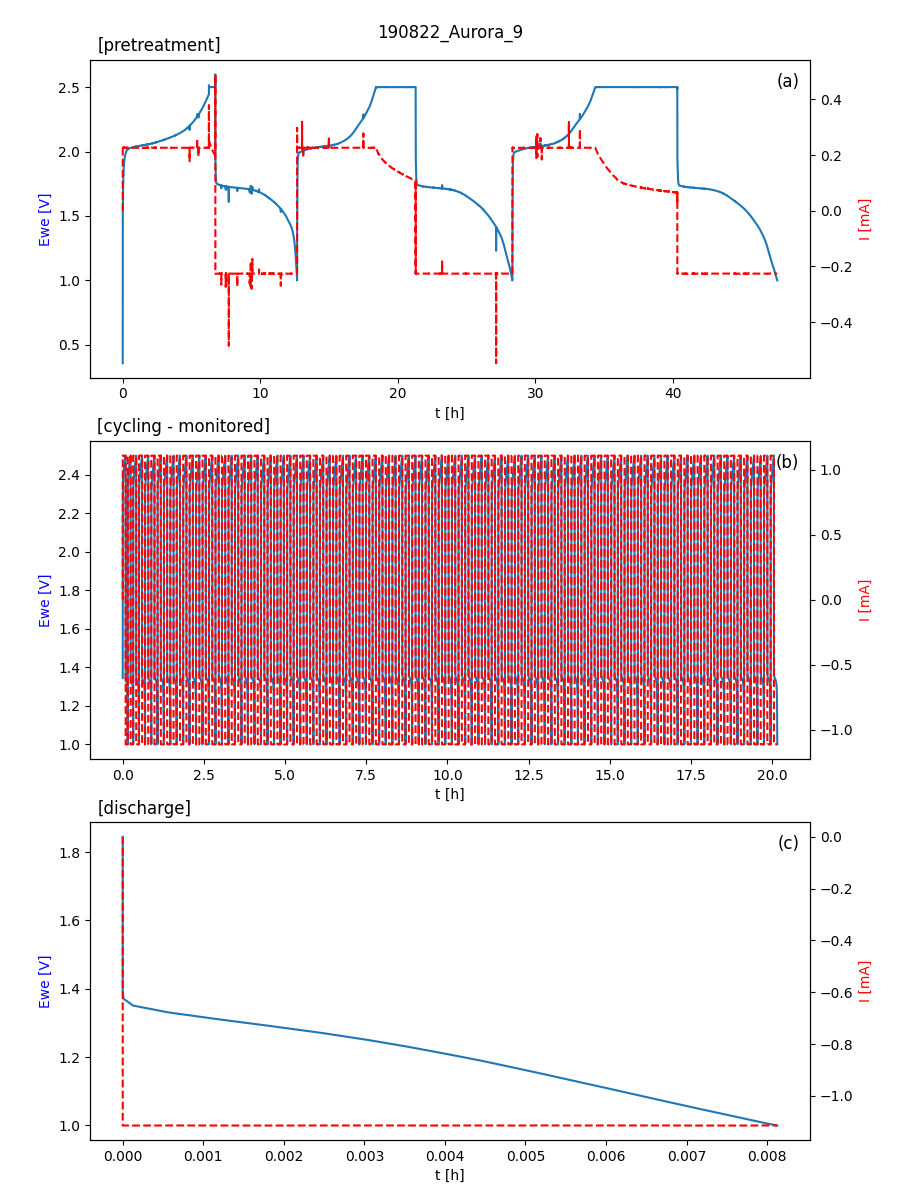

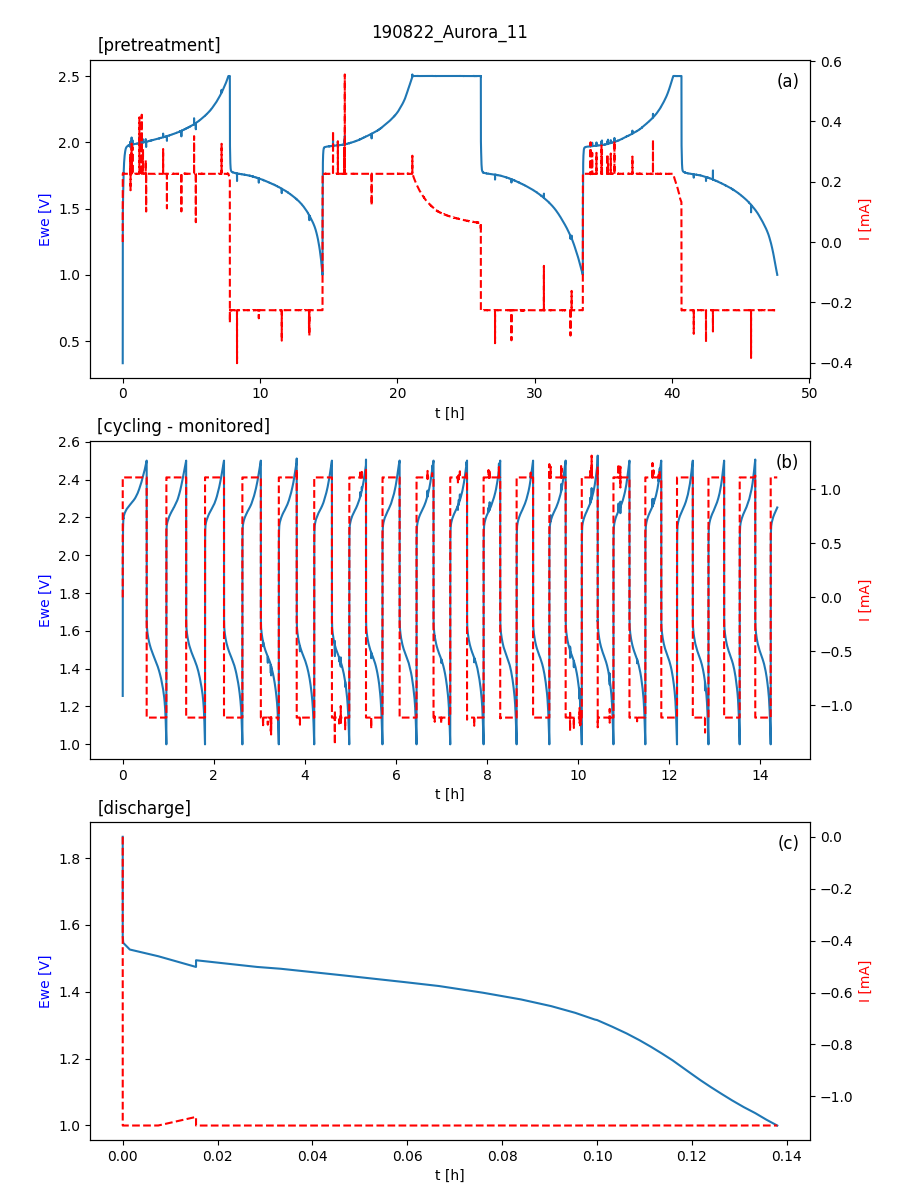

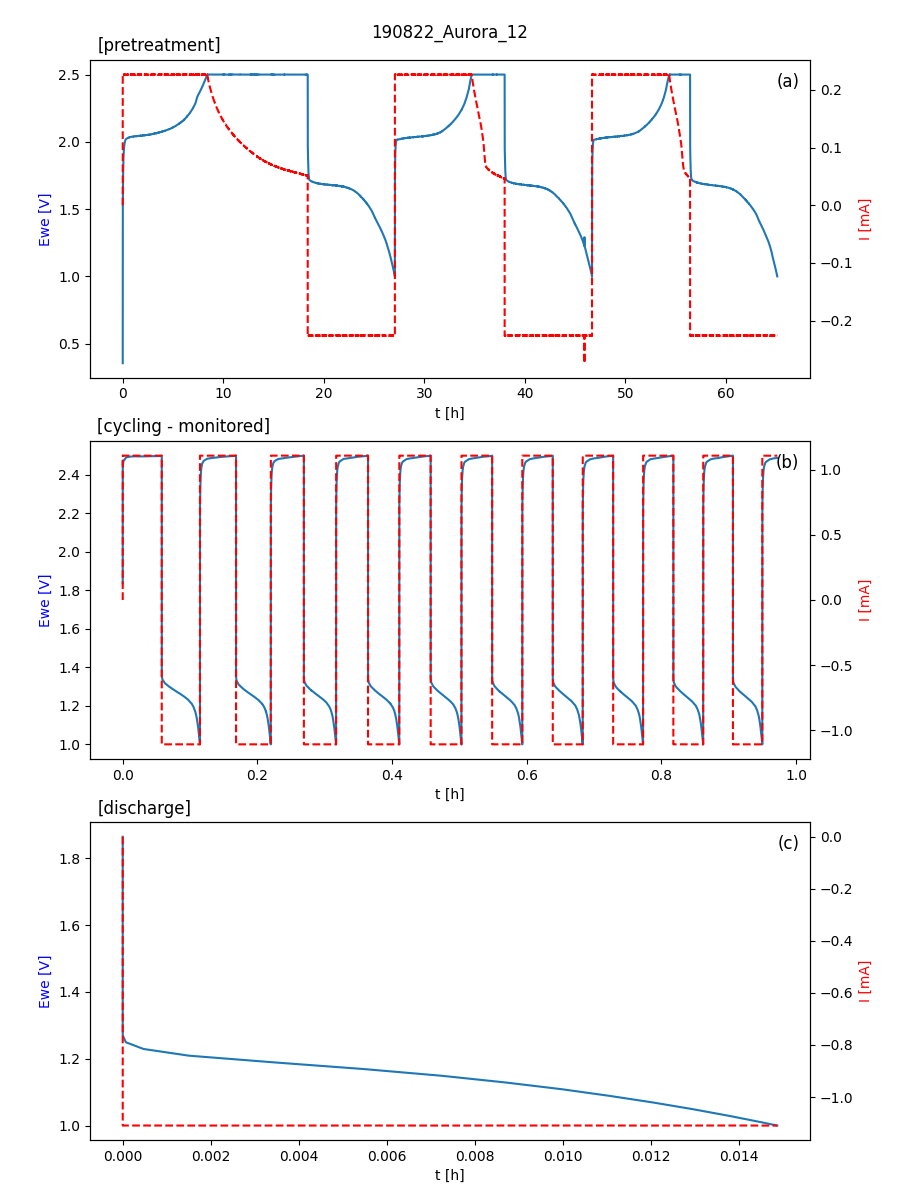

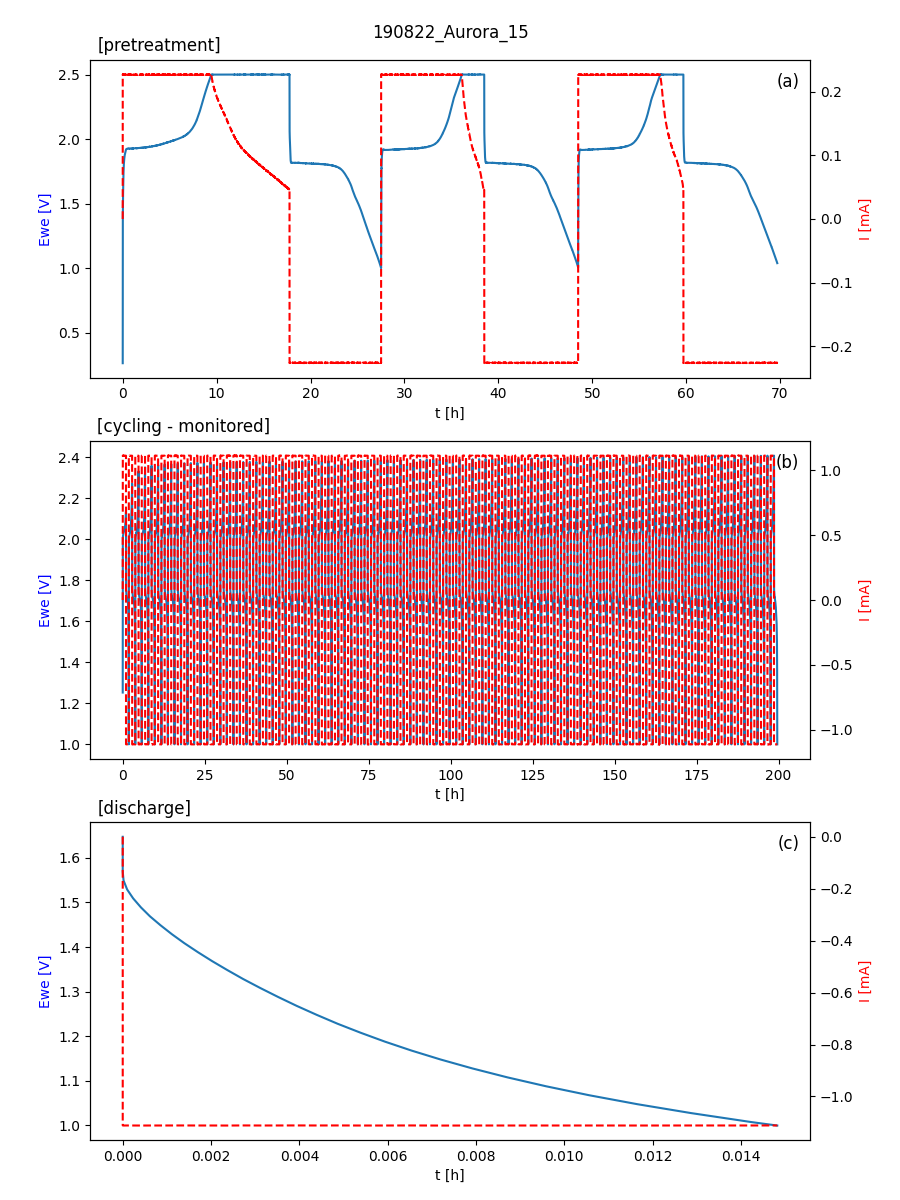

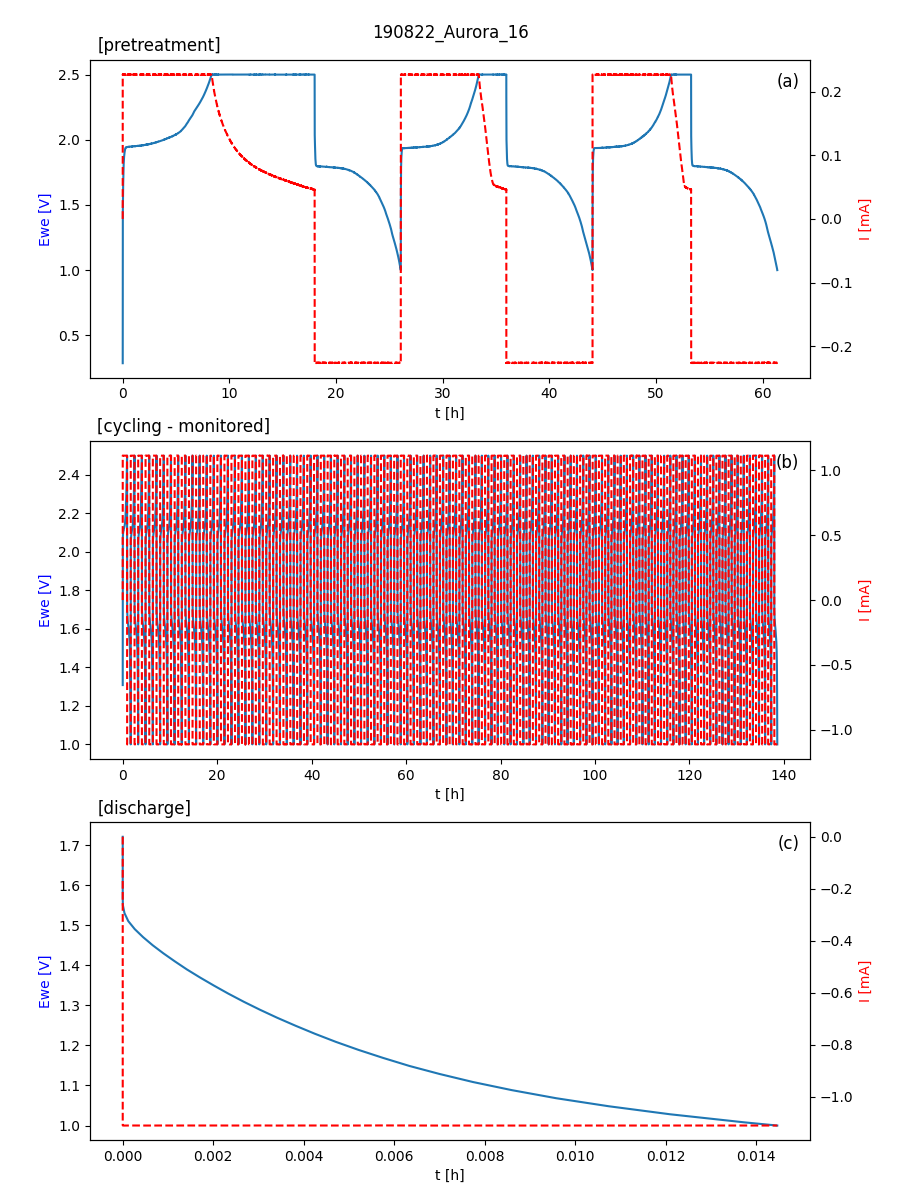

In [119]:
for name, data in cycl_data.items():
    plot_Ewe_I(data, name)

In [139]:
plt.close('all')

In [136]:
def plot_Qd(data, name, ytick=0.05):
    f, axx = plt.subplots(1, figsize=(9,4))
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9)
    axx.plot(range(1, len(data[1]['Qd']) + 1), data[1]['Qd'] / 3.6, '.-', label='Qd')
    axx.set_xlabel('cycle')
    axx.set_ylabel('Qd [mAh]')
    axx.axhline(data[1]['Qd'][0] * 0.8 / 3.6, ls='--', c='r')
    if len(data[1]['Qd']) < 20:
        axx.xaxis.set_minor_locator(MultipleLocator(1))
        axx.xaxis.set_major_locator(MultipleLocator(2))
    else:
        axx.xaxis.set_minor_locator(MultipleLocator(5))
        axx.xaxis.set_major_locator(MultipleLocator(10))
    axx.yaxis.set_minor_locator(MultipleLocator(ytick * 0.5))
    axx.yaxis.set_major_locator(MultipleLocator(ytick))
    axx.set_xlim([0, None])
    axx.text(0.99, 0.96, '(d)', transform=axx.transAxes, ha='right', va='top', fontsize=12)
    f.suptitle(name);
    plt.savefig(f'{BASE_DIR}/{name}_Qd.png', dpi=300)

190822_Aurora_9 0.07388642472719655
190822_Aurora_11 (killed by monitor) 0.481019629996178
190822_Aurora_12 (killed by monitor) 0.06297643965170148
190822_Aurora_15 0.9548824468338082
190822_Aurora_16 0.8610554203831539


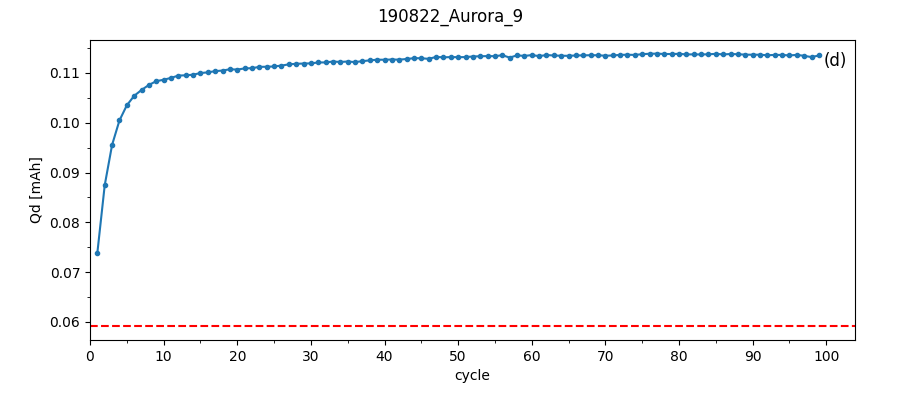

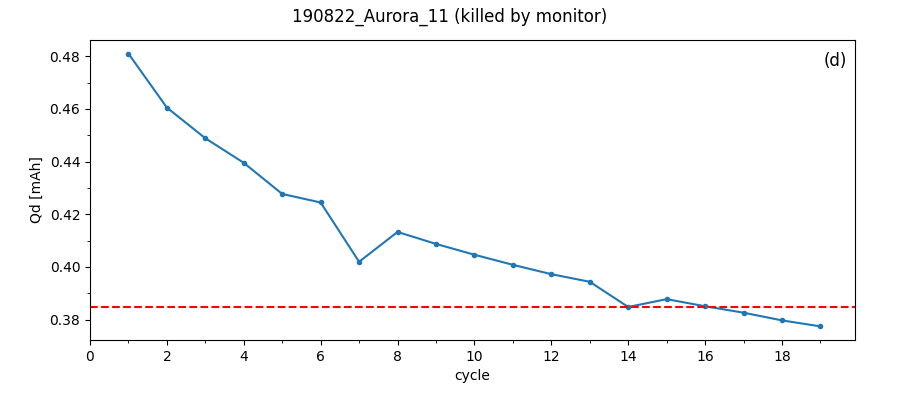

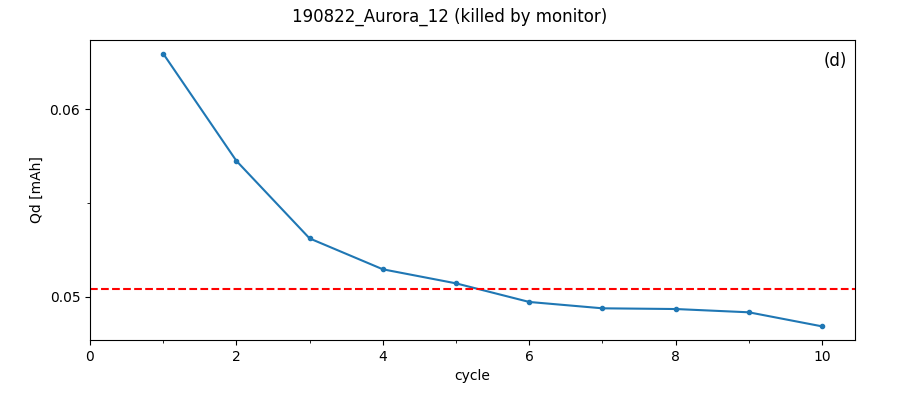

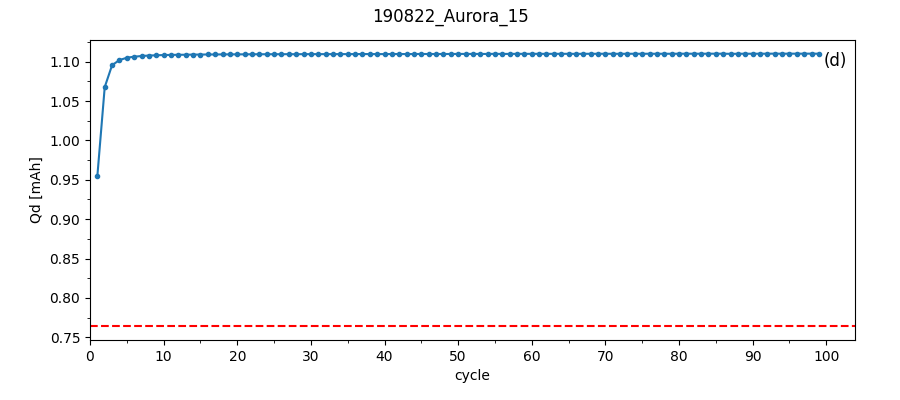

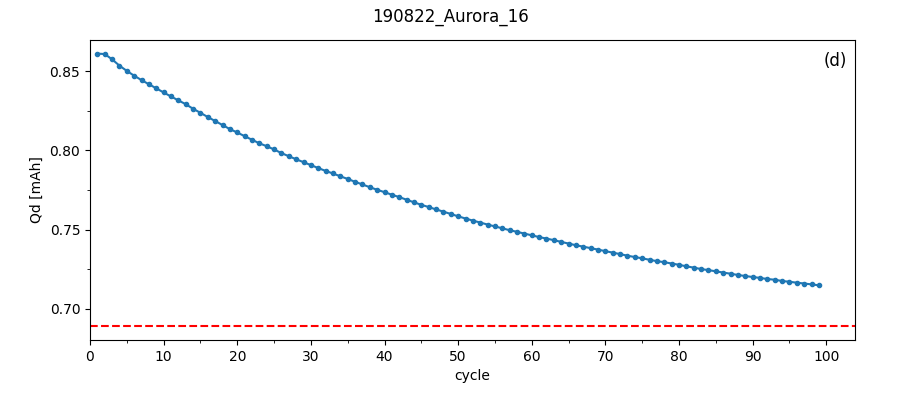

In [138]:
for (name, data), ytick in zip(cycl_data.items(), [0.01, 0.02, 0.01, 0.05, 0.05]):
    if '11' in name or '12' in name:
        name += ' (killed by monitor)'
    print(name, data[1]['Qd'][0] / 3.6)
    plot_Qd(data, name, ytick)

In [330]:
for sample, in qbs.iterall():
    qb = QueryBuilder()
    qb.append(BatterySampleData, filters={'uuid': sample.uuid}, tag='s')
    qb.append(BatteryCyclerExperiment, tag='exp', filters={'label': {'like': f'%cycling'}})
    assert qb.count() == 1
    job, = qb.first()
    print(job.label, job.process_state, job.process_status)

190822_Aurora_9-cycling ProcessState.FINISHED None
190822_Aurora_11-cycling ProcessState.KILLED Killed through `verdi process kill`
190822_Aurora_12-cycling ProcessState.KILLED Killed through `verdi process kill`
190822_Aurora_15-cycling ProcessState.FINISHED None
190822_Aurora_16-cycling ProcessState.FINISHED None
